# Úkol č. 1 - předzpracování dat a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz](https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzašším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s klasifikační úlohou s příznaky různých typů.
* Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem se vypořádejte s chybějícími hodnotami. _Pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **survived**. Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

  * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,survived
1000,0
1001,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.

# 0. Importy, priprava prostredi

In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import sklearn.metrics as metrics

random_seed = 42

# 1. Analyza a obecna priprava dat

In [3]:
df_orig_data = pd.read_csv("data.csv")
df_data = df_orig_data.copy(deep=True)

## First Look

In [4]:
df_data.head(3)


,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.90,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.05,NaN,S,NaN
2,2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.90,NaN,S,NaN


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        802 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      233 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  566 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


Hned vidime:
- bude potreba vyresit chybejici hodnoty (age, fare, cabin, embarked, home.dest)
- bude potreba udelat konverza na numericke type pro sloupce s typem object

In [6]:
df_data.select_dtypes(include=['int', 'float']).describe()

,ID,survived,pclass,age,sibsp,parch,fare
count,1000.000000,1000.00000,1000.000000,802.000000,1000.000000,1000.00000,999.000000
mean,499.500000,0.39800,2.288000,29.850686,0.496000,0.40200,34.264352
std,288.819436,0.48973,0.840096,14.328743,1.024223,0.91719,53.315077
min,0.000000,0.00000,1.000000,0.166700,0.000000,0.00000,0.000000
25%,249.750000,0.00000,1.750000,21.000000,0.000000,0.00000,7.925000
50%,499.500000,0.00000,3.000000,28.000000,0.000000,0.00000,14.458300
75%,749.250000,1.00000,3.000000,39.000000,1.000000,0.00000,31.275000
max,999.000000,1.00000,3.000000,80.000000,8.000000,9.00000,512.329200


- Hned vidime, ze zadna numericka hodnota neni zaporna

In [7]:
df_data.select_dtypes(include=['object']).describe()

,name,sex,ticket,cabin,embarked,home.dest
count,1000,1000,1000,233,998,566
unique,999,2,746,157,3,313
top,"Kelly, Mr. James",male,CA. 2343,B57 B59 B63 B66,S,"New York, NY"
freq,2,628,9,5,698,46


In [8]:
df_data.nunique()

ID           1000
survived        2
pclass          3
name          999
sex             2
age            95
sibsp           7
parch           8
ticket        746
fare          254
cabin         157
embarked        3
home.dest     313
dtype: int64

In [9]:
# jestli sloupec ma chybejici hodnoty
df_data.isna().any()

ID           False
survived     False
pclass       False
name         False
sex          False
age           True
sibsp        False
parch        False
ticket       False
fare          True
cabin         True
embarked      True
home.dest     True
dtype: bool

## Columns

### ID Column
***

In [10]:
df_data.head(3)

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.90,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.05,NaN,S,NaN
2,2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.90,NaN,S,NaN


Sloupec ID je úplně zbytečný:
 - index dataframu i tak popisuje ID.
 - má to 1000 unikatních hodnot, pro každý řádek, na predikci to nemá žádný vliv.

 Tato úprava se bude hodit pro oba modely, proto rovnou odstraníme tento sloupec.

In [11]:
df_data.drop(columns=["ID"], inplace=True)

In [12]:
df_data.head(3)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.90,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.05,NaN,S,NaN
2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.90,NaN,S,NaN


### Survived
***

Tento sloupec je v poradku:
 - nabyva pouze hodnot 0 a 1 - true nebo false
 - datovy typ je int64 - taky v poradku


In [13]:
df_data['survived'].unique()

array([0, 1])

In [14]:
df_data['survived'].value_counts()

survived
0    602
1    398
Name: count, dtype: int64

Zadne upravy provadet nemusime

### Pclass
***

- Nema chybejici hodnoty
- Unikatni hodnoty jsou 1, 2, 3
- Datovy typ je int64

In [15]:
df_data['pclass'].unique()

array([3, 2, 1])

Pro tento priznak ma smysl ho udelat kategorickym ordinalnim, jelikoz plati:

3. class < 2. class < 1. class

Tato uprava potom bude se hodit pro oba modely, takze to provedeme hned.

In [16]:
cat_pclass = CategoricalDtype(categories=[3, 2, 1], ordered=True)
df_data['pclass'] = df_data['pclass'].astype(cat_pclass)

 

In [17]:
df_data['pclass'].head()

0    3
1    3
2    3
3    3
4    3
Name: pclass, dtype: category
Categories (3, int64): [3 < 2 < 1]

In [18]:
df_data['pclass'].cat.codes.head()

0    0
1    0
2    0
3    0
4    0
dtype: int8

Je videt, ze to nahradilo 3. tridu za nejmensi hodnotu, pri dalsim pozorovani lze uvidet jak to 1. tridy nahradilo za 3, coz je numericky nejvetsi hodnota.

### Name
***

- Nema chybejici hodnoty
- ma 999 unikatnich hodnot, 1 hodnota je duplicitni

In [19]:
df_data[df_data['name'] == 'Kelly, Mr. James']

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
651,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN
964,0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S,NaN


In [20]:
df_data.loc[212]

survived                                                1
pclass                                                  1
name         Widener, Mrs. George Dunton (Eleanor Elkins)
sex                                                female
age                                                  50.0
sibsp                                                   1
parch                                                   1
ticket                                             113503
fare                                                211.5
cabin                                                 C80
embarked                                                C
home.dest                                 Elkins Park, PA
Name: 212, dtype: object

In [21]:
df_data[df_data['name'].str.contains('Widener')]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
212,1,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5,C80,C,"Elkins Park, PA"
866,0,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5,C80,C,"Elkins Park, PA"


Vidime, ze podle jmena da se rozeznat, kdo jsou manzele. 

To se da vyuzit, abychom mohli roztrhnout priznak sibsp - siblings/spouses a mit lepsi dataset.

Ohledne toho, jestli by to byla metodicka chyba:
- na jednu stranu data nemenime - pouze je rozdelime - odtrhneme siblingy a spouses od sebe.
- na druhou stranu muzeme vyuzit znalosti z dat, ktere budou testovaci a pak to ovlivni presnost modelu.

Spravny postup by byl nejprve rozdelit data na trenovaci, validacni a testovaci, a potom na trenovacich zkusit aplikovat danou transformaci, zapamotovat z toho potreba metadata (fit), a potom na zaklade dat z trenovaci mnoziny aplikovat stejnou transformaci (transform) na validacni a testovaci data nezavisle od toho, co je ve validacnich a testovaci datech.

Zatim pro jednoduchost proste odstranime tento sloupec pro oba modely. Samotne jmeno jako priznak vyuzit je dost tezke, je potreba vymyslet jak to numerizovat aby to bylo uzitecne a naopak neuskodilo predikci.

In [22]:
df_data.drop(columns=['name'], inplace=True)

In [23]:
df_data.head(3)

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,3,male,11.0,5,2,CA 2144,46.90,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,0,3,male,NaN,0,0,SOTON/O.Q. 3101305,7.05,NaN,S,NaN
2,0,3,male,4.0,3,2,347088,27.90,NaN,S,NaN


### Sex
***

- zadne chybejici hodnoty
- pouze dve unikatni hodnoty type string - female a male

In [24]:
df_data['sex'].unique()

array(['male', 'female'], dtype=object)

Prevedeme to na kategoricky priznak nominalni.

Jelikoz se jedna o binarni priznak - bude to vhodne jak pro DT tak i pro kNN a v pripade posledniho zadny one-hot encoding neni potreba, protoze ten priznak je sam o sobe one-hot encoding.

In [25]:
cat_sex = CategoricalDtype(categories=["male", "female"])

In [26]:
df_data["sex"] = df_data["sex"].astype(cat_sex)
df_data["sex"].head()

0      male
1      male
2      male
3    female
4    female
Name: sex, dtype: category
Categories (2, object): ['male', 'female']

In [27]:
df_data['sex'].cat.codes.head()

0    0
1    0
2    0
3    1
4    1
dtype: int8

### Age
***

- float64 - numericky priznak 
- **obsahuje chybejici hodnoty** 
- **95** unikatnich

In [28]:
df_data['age'].describe()

count    802.000000
mean      29.850686
std       14.328743
min        0.166700
25%       21.000000
50%       28.000000
75%       39.000000
max       80.000000
Name: age, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb1b1503750>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb1b150d090>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb1b1502f90>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb1b150e7d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb1b150f210>],
 'means': []}

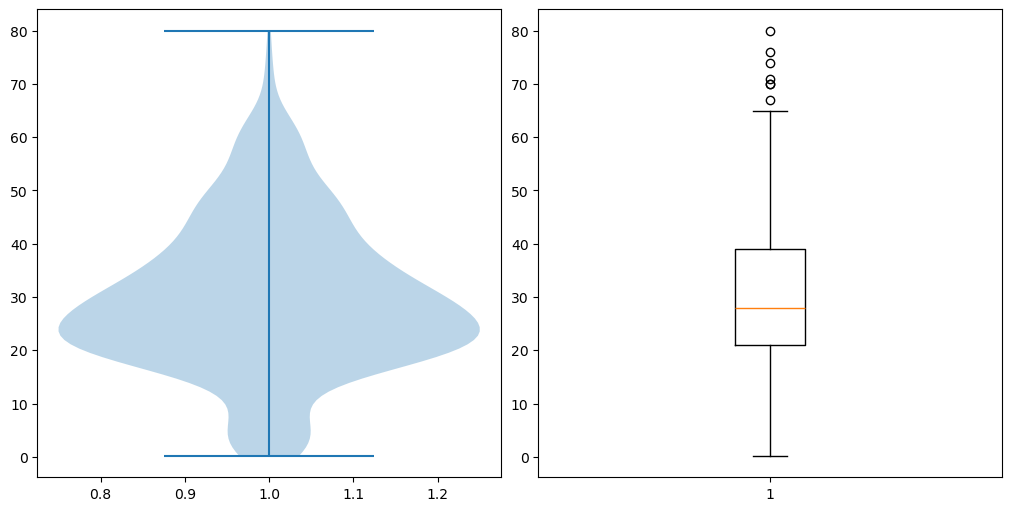

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,5))
ax1.violinplot(df_data['age'].dropna())
ax2.boxplot(df_data['age'].dropna())

Jak muzeme videt, mame odlehle hodnoty. Pro DT by to nemelo vadit, ale pro kNN v pripade normalizaci dat to muze mit vliv.

Pozdeji muzeme zkusit polepsit situaci tim, ze na zaklade trenovaci dat najdeme IQR, a odlehle hodnoty zkratime na prislusny interval. Anebo proste odstranime radky s odlehlymi hodnotami (kterych je jenom 6)

Co se tyce chybejicich hodnot:
- muzeme z trenovacich dat spocitat median (fit) (odolny na odlehle hodnoty ktere mame) a pak tento median priradit (transform) pro chybejici hodnoty ve validacnich a testovacich datech. Problem je ze mame mamlo dat, a ten median v zavislosti na rozdeleni muze potom ruzne ovlivnit evaluaci. V tomto pripade by hodne pomohla cross-validace, protoze bychom vyzkouseli vsechna mozna rozdeleni promichanych dat, ale i tak by to nebylo idealni.

Zatim ale pro oba modely urcite zamenime NaN na -1, protoze modely nepracuji s null hodnotami, potom pripade muzeme tuto situaci zkusit polepsit.

In pandas, median ignores nan values

In [30]:
df_data['age'].fillna(value=-1, inplace=True)

In [31]:
df_data['age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: age
Non-Null Count  Dtype  
--------------  -----  
1000 non-null   float64
dtypes: float64(1)
memory usage: 7.9 KB


In [32]:
df_data['age'].head()

0    11.0
1    -1.0
2     4.0
3    -1.0
4    18.0
Name: age, dtype: float64

### Sibsp
***

Tento priznak reprezentuje pocet sourezencu a manzelu dohromady

- nema chybejici hodnoty
- ma datovy typ int64
- minimum je 0, maximum je 8

Jediny problem je, ze manzele a sourozence jsou spolu. Mohli bychom zkusit potom dle jmena roztrhnout to na dva priznaky, ale zatim nechame to tak jak to je.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb1b15786d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb1a9051cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb1b1503510>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb1a9053390>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb1a9053e50>],
 'means': []}

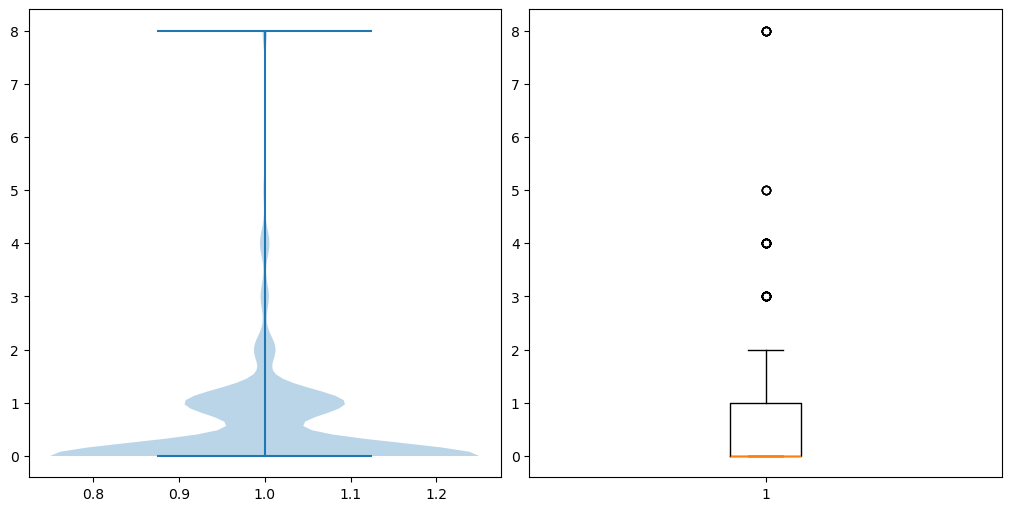

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,5))
ax1.violinplot(df_data['sibsp'].dropna())
ax2.boxplot(df_data['sibsp'].dropna())

Zase vidime docela silne odlehle hodnoty.

Hodnota 8 muze mit zasadni vliv pri normalizaci pro kNN.

 DT jsou obecne robustni k odlehlym hodnotam.

In [34]:
# pocetnost unikatnich hodnot
df_data['sibsp'].value_counts().sort_index()

sibsp
0    674
1    253
2     34
3     13
4     15
5      4
8      7
Name: count, dtype: int64

### Parch
***

parch - parents/children - rodice/deti
- podobna situace jako s sibsp
- zadne chybejici hodnoty
- typ int64

In [35]:
df_data['parch'].unique()

array([2, 0, 1, 3, 5, 6, 4, 9])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb1a941bd50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb1a9429490>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb1a941b390>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb1a942ab90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb1a942b650>],
 'means': []}

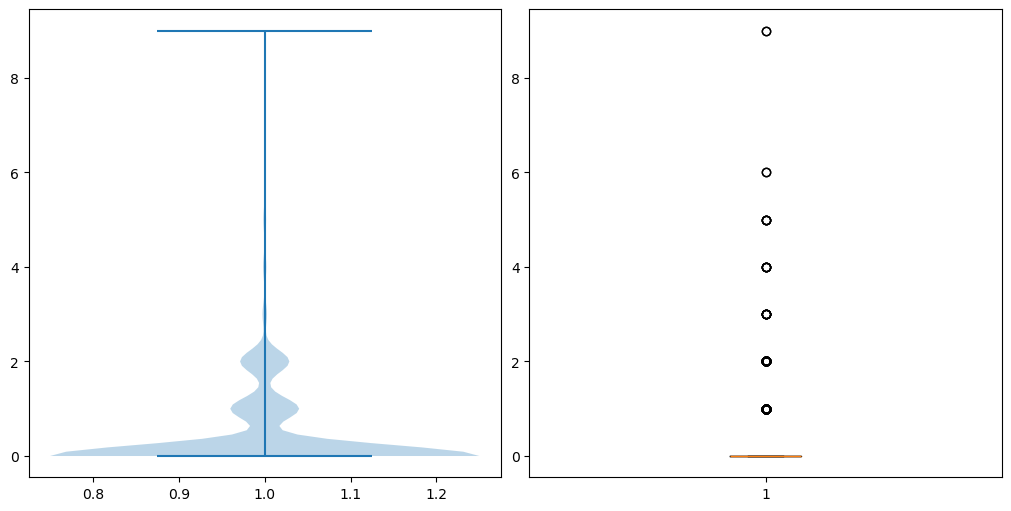

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,5))
ax1.violinplot(df_data['parch'].dropna())
ax2.boxplot(df_data['parch'].dropna())

Tento sloupec ma asi ze vsech nejsilnejsi outliery. Naprosta vetsina nema zadne deti ani rodice na lodi.

In [37]:
df_data['parch'].value_counts().sort_index()

parch
0    766
1    123
2     88
3      8
4      6
5      5
6      2
9      2
Name: count, dtype: int64

Zatim nechame tento sloupec tak jak je.

### ticket
***

- zadne chybejici hodnoty
- datovy typ je string
- 746 unikatnich hodnot

In [38]:
df_data['ticket'].head()

0               CA 2144
1    SOTON/O.Q. 3101305
2                347088
3                370365
4                  2657
Name: ticket, dtype: object

Mame dost hodne duplicitnich ticketu - predpokladam ze se jedna nejspise o manzele/deti/rodice/sourozence

In [39]:
df_data[df_data['ticket'].duplicated()].head()

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
113,0,2,female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S,"Southampton / New York, NY"
116,1,2,female,34.0,1,1,28220,32.5000,NaN,S,"Greenport, NY"
139,0,3,female,14.5,1,0,2665,14.4542,NaN,C,NaN
149,0,1,male,23.0,0,0,12749,93.5000,B24,S,"Montreal, PQ"
154,0,3,male,34.0,1,1,347080,14.4000,NaN,S,"Stanton, IA"


In [40]:
df_orig_data[df_data['ticket'] == '28220']

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
10,10,1,2,"Drew, Master. Marshall Brines",male,8.0,0,2,28220,32.5,NaN,S,"Greenport, NY"
116,116,1,2,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",female,34.0,1,1,28220,32.5,NaN,S,"Greenport, NY"
762,762,0,2,"Drew, Mr. James Vivian",male,42.0,1,1,28220,32.5,NaN,S,"Greenport, NY"


Hned vidime, ze tickety se daji velmi dobre vyuzit pro rozdeleni sibsp a parch, stejnych zpusobem jako name. 

Zatim se tim zabyvat nebudeme a nechame jako ideu na pripadne pouziti - ted proste tento sloupec odstranime pro oba modely.

In [41]:
df_data.drop(columns=['ticket'], inplace=True)

In [42]:
df_data.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,home.dest
0,0,3,male,11.0,5,2,46.90,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,0,3,male,-1.0,0,0,7.05,NaN,S,NaN
2,0,3,male,4.0,3,2,27.90,NaN,S,NaN


### fare
***

- pouze jedna chybejici hodnota
- typ float64

In [43]:
df_data['fare'].head()

0    46.9000
1     7.0500
2    27.9000
3    15.5000
4     7.2292
Name: fare, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb1a8f19690>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb1a8f1aa50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb1a939c590>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb1a8f24050>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb1a8f24b90>],
 'means': []}

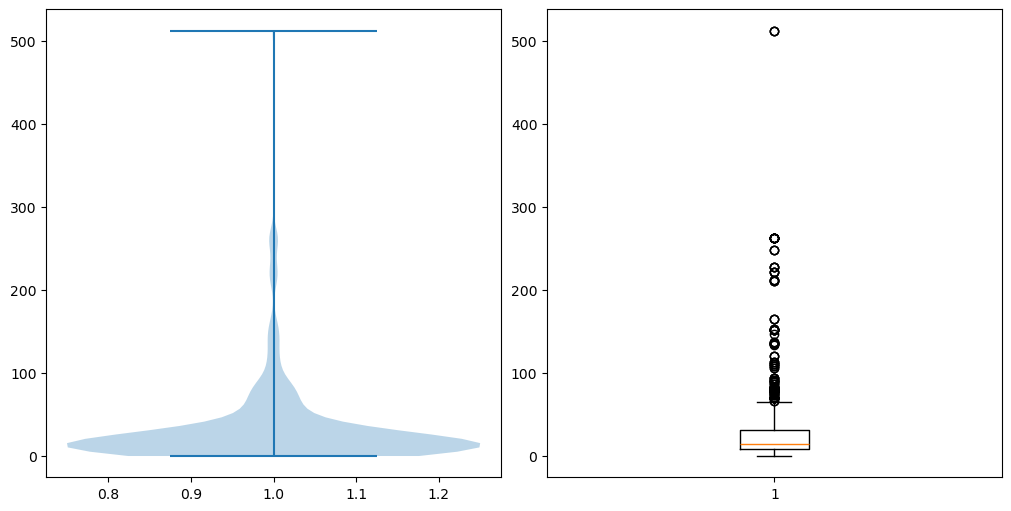

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,5))
ax1.violinplot(df_data['fare'].dropna())
ax2.boxplot(df_data['fare'].dropna())

Zase vidime problem s odlehlymi hodnotami, ktery potom bude potreba vzit v uvahu u kNN pri normalizaci

Ted chybejici hodnotu nahradime -1

In [45]:
df_data['fare'].fillna(value=-1, inplace=True)

### cabin
***

- datovy typ je string 
- ma 1000 - 223 = 777 chybejici hodnot

In [46]:
df_data['cabin'].unique()

array([nan, 'B30', 'C49', 'C83', 'F4', 'C99', 'C62 C64',
       'B57 B59 B63 B66', 'B102', 'B58 B60', 'B5', 'D20', 'D40', 'B101',
       'B37', 'F E57', 'C78', 'E121', 'B41', 'C116', 'E58', 'C124', 'D15',
       'E77', 'B69', 'E101', 'C52', 'C92', 'D19', 'C23 C25 C27', 'D17',
       'B24', 'B96 B98', 'B22', 'D', 'B50', 'C22 C26', 'B45', 'C103',
       'D46', 'B39', 'B35', 'E25', 'C65', 'F38', 'A24', 'C47', 'C91',
       'C7', 'F2', 'E24', 'C80', 'A6', 'C148', 'C106', 'E12', 'C54',
       'D30', 'B73', 'D28', 'C123', 'C51', 'E63', 'A19', 'F G63', 'E46',
       'C46', 'C126', 'B49', 'D37', 'E36', 'B18', 'D26', 'B77', 'A11',
       'A34', 'A20', 'B79', 'E44', 'C93', 'D33', 'F33', 'A5', 'D36',
       'C32', 'B28', 'C89', 'C39', 'C30', 'C101', 'B71', 'E10', 'E33',
       'D11', 'C55 C57', 'F E69', 'B10', 'B51 B53 B55', 'B4', 'E52', 'F',
       'E34', 'E67', 'A31', 'D50', 'E60', 'A18', 'G6', 'D48', 'C132',
       'A7', 'C68', 'A36', 'D56', 'A23', 'C2', 'C105', 'D22', 'D35',
       'B78', 'D3

In [47]:
df_data['cabin'].dropna().duplicated().sum()

76

Vidime ze to ma hodne i duplikovanych hodnot - to znamena ze zase muzeme analyzovat kdo je s kym. 

Mohli zkusit numerizovat tyto hodnoty, ale neni zatim jasno jake usporadani pismenek A-G (dle trid?), a navic mame hodnoty jako 'B52 B54 B56', ktere zatim nevime jak numerizovat.

Pro jednoduchost vynechame tento sloupec, pripadne se vratime.

In [48]:
df_data.drop(columns=["cabin"], inplace=True)

### embarked 
***

- jenom 2 chybejici hodnoty.

In [49]:
df_data['embarked'].unique()

array(['S', 'Q', 'C', nan], dtype=object)

- opravdu zalezi na preziti, z jakeho mista clovek nastoupil na lod? Lze zase analyzovat a zkusit nakreslit nejaky bar plot atd. My zatim tento priznak nechame.
- priznak je kategoricky nominalni, ale neni ordinalni, navic ma pouze 3 unikatni hodnoty -> pouzijeme one-hot encoding pro oba modely. Chybejici hodnoty budou mit false v kazdem embarked_* sloupci

In [50]:
df_data = pd.get_dummies(data=df_data, columns=['embarked'])

In [51]:
df_data.head()

,survived,pclass,sex,age,sibsp,parch,fare,home.dest,embarked_C,embarked_Q,embarked_S
0,0,3,male,11.0,5,2,46.9000,"Wiltshire, England Niagara Falls, NY",False,False,True
1,0,3,male,-1.0,0,0,7.0500,NaN,False,False,True
2,0,3,male,4.0,3,2,27.9000,NaN,False,False,True
3,1,3,female,-1.0,1,0,15.5000,NaN,False,True,False
4,1,3,female,18.0,0,0,7.2292,"Greensburg, PA",True,False,False


### home.dest
***

- skoro pulka hodnot chybi
- zase, je to string a muzeme vyuzit k tomu, abychom mohli rozdelit lidi na rodiny/rodice/deti/manzele atd..

In [52]:
df_data['home.dest'].nunique()

313

Zaroven vidime ze to ma hodne unikatnich hodnot - 313 z 566.

Tento sloupec vynechame, protoze zase neni moc jasno jak to vhodne numerizovat.

In [53]:
df_data.drop(columns=['home.dest'], inplace=True)

In [54]:
df_data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,0,3,male,11.0,5,2,46.9000,False,False,True
1,0,3,male,-1.0,0,0,7.0500,False,False,True
2,0,3,male,4.0,3,2,27.9000,False,False,True
3,1,3,female,-1.0,1,0,15.5000,False,True,False
4,1,3,female,18.0,0,0,7.2292,True,False,False


## Finalni vysledky zpracovani dat a prevod na cat.codes

In [55]:
df_data.isna().any()

survived      False
pclass        False
sex           False
age           False
sibsp         False
parch         False
fare          False
embarked_C    False
embarked_Q    False
embarked_S    False
dtype: bool

In [56]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    1000 non-null   int64   
 1   pclass      1000 non-null   category
 2   sex         1000 non-null   category
 3   age         1000 non-null   float64 
 4   sibsp       1000 non-null   int64   
 5   parch       1000 non-null   int64   
 6   fare        1000 non-null   float64 
 7   embarked_C  1000 non-null   bool    
 8   embarked_Q  1000 non-null   bool    
 9   embarked_S  1000 non-null   bool    
dtypes: bool(3), category(2), float64(2), int64(3)
memory usage: 44.3 KB


Oba modely neakceptuji kategoricka data, proto vymenime je jejich kategorickymi kody

In [57]:
for col in df_data.select_dtypes(['category']).columns:
    df_data[col] = df_data[col].cat.codes

In [58]:
df_data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,0,0,0,11.0,5,2,46.9000,False,False,True
1,0,0,0,-1.0,0,0,7.0500,False,False,True
2,0,0,0,4.0,3,2,27.9000,False,False,True
3,1,0,1,-1.0,1,0,15.5000,False,True,False
4,1,0,1,18.0,0,0,7.2292,True,False,False


In [59]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    1000 non-null   int64  
 1   pclass      1000 non-null   int8   
 2   sex         1000 non-null   int8   
 3   age         1000 non-null   float64
 4   sibsp       1000 non-null   int64  
 5   parch       1000 non-null   int64  
 6   fare        1000 non-null   float64
 7   embarked_C  1000 non-null   bool   
 8   embarked_Q  1000 non-null   bool   
 9   embarked_S  1000 non-null   bool   
dtypes: bool(3), float64(2), int64(3), int8(2)
memory usage: 44.1 KB


# 2. Decision Trees

### Vhodnost pro dany typ ulohy

Obecne:
Decision trees, while popular for their simplicity and interpretability, do have several limitations:

Overfitting:

Decision trees can easily overfit the data, especially if they are allowed to grow deep. Overfitting happens when the tree starts to learn noise and details in the training data that do not generalize well to unseen data.
Instability:

They are sensitive to small variations in the data. Slight changes in the input data can result in a very different tree structure. This instability can be problematic in applications where consistency is key.
Handling of Linear Relationships:

Decision trees do not handle linear relationships between features and the target variable as well as other methodologies like linear regression. They are non-parametric, so they divide the feature space into rectangular regions, which might not capture linear relationships effectively.
Difficulty with High-Dimensional Data:

Performance and interpretability can degrade with an increase in the number of features, particularly if many features are irrelevant. This is partly due to the "curse of dimensionality".
Bias towards Features with More Levels:

Decision trees can be biased towards selecting features with more levels (e.g., categorical variables with a high number of categories) for splitting.
Handling of Missing Values:

Unlike some algorithms that have built-in mechanisms for handling missing data, decision trees typically require complete data or imputation of missing values.
Limited to Axis-Parallel Splits:

Traditional decision trees make splits that are parallel to the axis of the feature space, which can be limiting in certain scenarios.
Inefficiency with Continuous Variables:

For continuous variables, decision trees make binary splits, and finding the optimal split point can be computationally expensive and may not always capture the nature of the variable effectively.
Despite these limitations, decision trees are a foundational element for many powerful machine learning models, such as Random Forests and Gradient Boosting Machines, which overcome many of these limitations through ensemble methods.

### Priprava a rozdeleni dat

In [60]:
df_DT = df_data.copy(deep=True)

In [61]:
df_DT.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,0,0,0,11.0,5,2,46.90,False,False,True
1,0,0,0,-1.0,0,0,7.05,False,False,True
2,0,0,0,4.0,3,2,27.90,False,False,True


Dalsi upravy na datech zatim provadet nebudeme, jenom je rozdelime na trenovaci, validacni a testovaci

In [62]:
# 60% trenovaci, 40% zbytek
Xtrain, Xrest, ytrain, yrest = train_test_split(
    df_DT.drop(columns=["survived"]), df_DT["survived"], test_size=0.4
)

# 0.4*0.6 = 0.24 -> 24% validacni, 0.4*0.4 = 0.16 -> 16% testovaci
Xtest, Xval, ytest, yval = train_test_split(
    Xrest, yrest, test_size=0.6
)

### Trenovani a evaluace

#### Bez cross validace
***

In [63]:
param_grid = {
    'max_depth': range(1,30),
    'criterion': ['entropy','gini']
}
param_comb = ParameterGrid(param_grid)

In [64]:
val_acc = []
train_acc = []
for params in param_comb:
    clfDT = DecisionTreeClassifier(**params)
    clfDT.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, clfDT.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, clfDT.predict(Xval)))

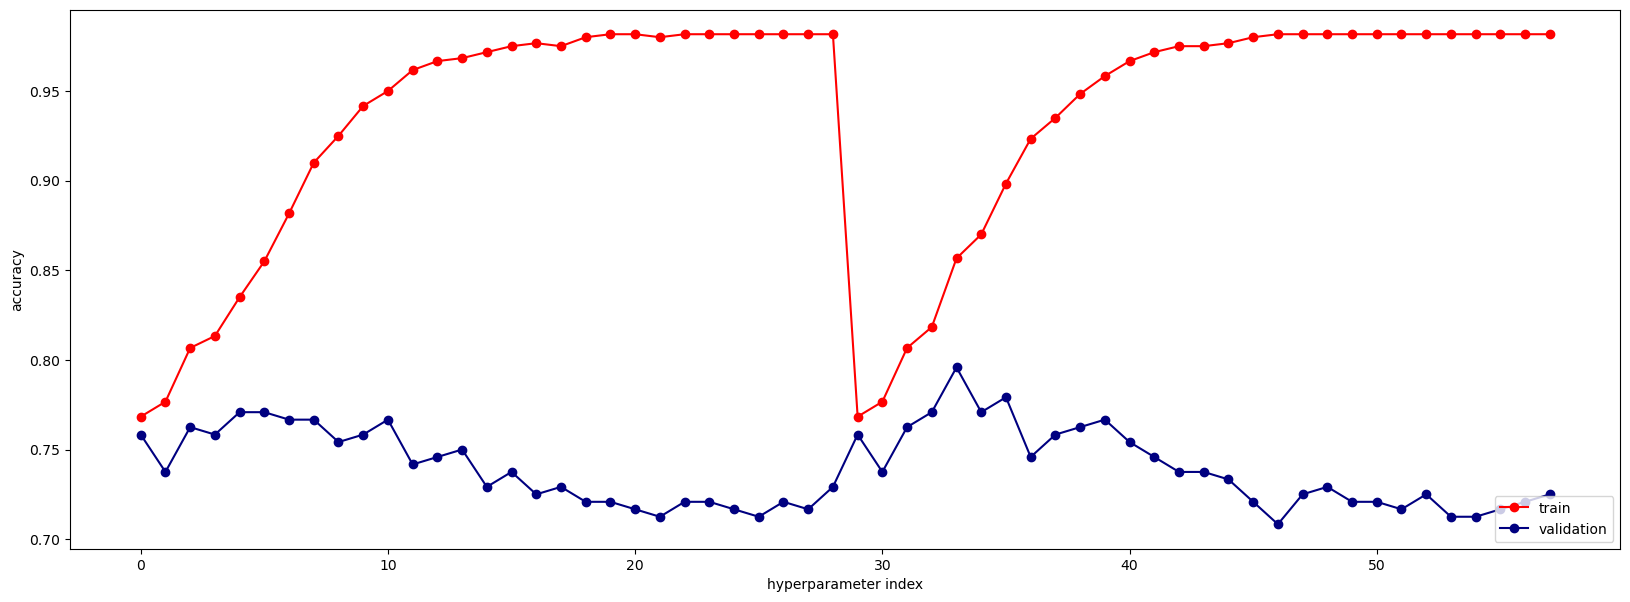

In [65]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(train_acc, 'o-', label='train', color='red')
ax.plot(val_acc, 'o-', label='validation', color='navy')
ax.set_xlabel('hyperparameter index')
ax.set_ylabel('accuracy')
ax.legend(loc="lower right")

In [66]:
best_params = param_comb[np.argmax(val_acc)]
best_params

{'max_depth': 5, 'criterion': 'gini'}

In [67]:
best_clfDT = DecisionTreeClassifier(**best_params) 
best_clfDT.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=5)

In [68]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_clfDT.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_clfDT.predict(Xval))))

accuracy score (train): 0.856667
accuracy score (validation): 0.795833


In [69]:
def evaluate(clf, X, y_true, title = "ROC curve"):
    ypred = clf.predict(X)
    ypred_proba = clf.predict_proba(X)
    p1_hat = ypred_proba[:, 1]

    f1_score = metrics.f1_score(y_true=y_true, y_pred=ypred)
    accuracy = metrics.accuracy_score(y_true=y_true, y_pred=ypred)
    fpr, tpr, thr = metrics.roc_curve(y_true=y_true, y_score=p1_hat)
    auc = metrics.roc_auc_score(y_true=y_true, y_score=p1_hat)

    fig, ax = plt.subplots()

    label = "\n".join(
        [
            f"ROC curve (AUC = {auc:.3f})",
            f"F1 = {f1_score:.3f}",
            f"Accuracy = {accuracy:.3f}",
        ]
    )
    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.plot(fpr, tpr, color="darkorange", lw=2, label=label)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")

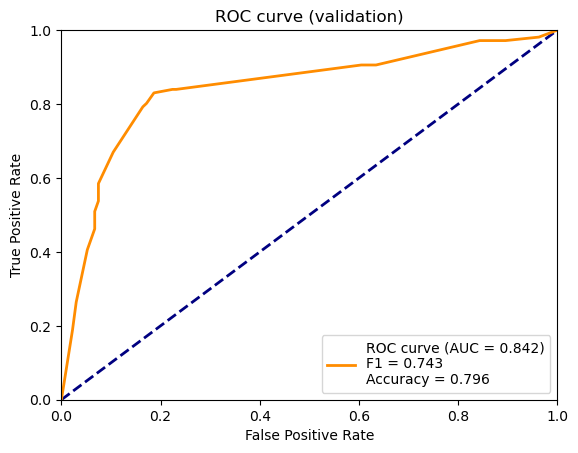

In [70]:
evaluate(clf=best_clfDT, X=Xval, y_true=yval, title='ROC curve (validation)')

#### Cross validace
***

In [71]:
k_folds = 5

val_acc = []
train_acc = []


for params in param_comb:
    clfDT = DecisionTreeClassifier(**params)

    val_fold_accuracy = np.mean(cross_val_score(estimator=clfDT, X=Xval, y=yval, cv=5))
    train_fold_accuracy = np.mean(
        cross_val_score(estimator=clfDT, X=Xtrain, y=ytrain, cv=5)
    )

    val_acc.append(val_fold_accuracy)
    train_acc.append(train_fold_accuracy)

In [72]:
best_params = param_comb[np.argmax(val_acc)]
best_params

{'max_depth': 1, 'criterion': 'entropy'}

In [73]:
best_clfDT = DecisionTreeClassifier(**best_params) 
best_clfDT.fit(Xtrain, ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [74]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_clfDT.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_clfDT.predict(Xval))))

accuracy score (train): 0.768333
accuracy score (validation): 0.758333


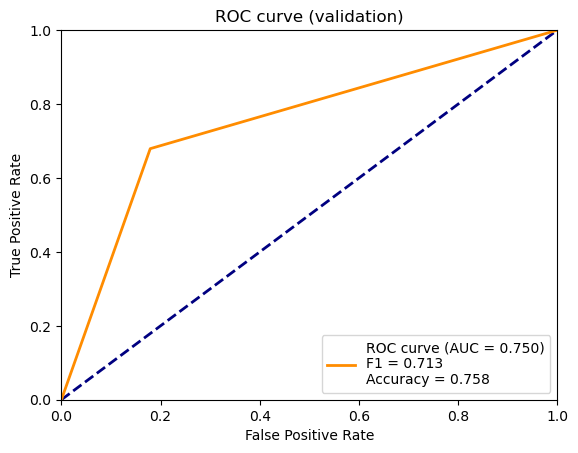

In [75]:
evaluate(clf=best_clfDT, X=Xval, y_true=yval, title='ROC curve (validation)')

# 3. kNN

### Vhodnost pro dany typ ulohy

- Mame outlieri - ty hodne ovlivnuji pri min-max normalizaci - problem

### Priprava a rozdeleni dat

In [76]:
df_KNN = df_data.copy(deep=True)

In [77]:
df_KNN.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,0,0,0,11.0,5,2,46.90,False,False,True
1,0,0,0,-1.0,0,0,7.05,False,False,True
2,0,0,0,4.0,3,2,27.90,False,False,True


Dalsi upravy na datech zatim provadet nebudeme, jenom je rozdelime na trenovaci, validacni a testovaci

In [78]:
# 60% trenovaci, 40% zbytek
Xtrain, Xrest, ytrain, yrest = train_test_split(
    df_KNN.drop(columns=["survived"]), df_KNN["survived"], test_size=0.4
)

# 0.4*0.6 = 0.24 -> 24% validacni, 0.4*0.4 = 0.16 -> 16% testovaci
Xtest, Xval, ytest, yval = train_test_split(Xrest, yrest, test_size=0.6)

### Trenovani

#### Bez normalizace dat
***

In [80]:
param_grid = {
    "n_neighbors": range(1, 15),
    "weights": ["uniform", "distance"],
    "p": [1, 2, 3],
}
param_comb = ParameterGrid(param_grid)

In [81]:
val_acc = []
train_acc = []
for params in param_comb:
    clfKNN = KNeighborsClassifier(**params)
    clfKNN.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, clfKNN.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, clfKNN.predict(Xval)))

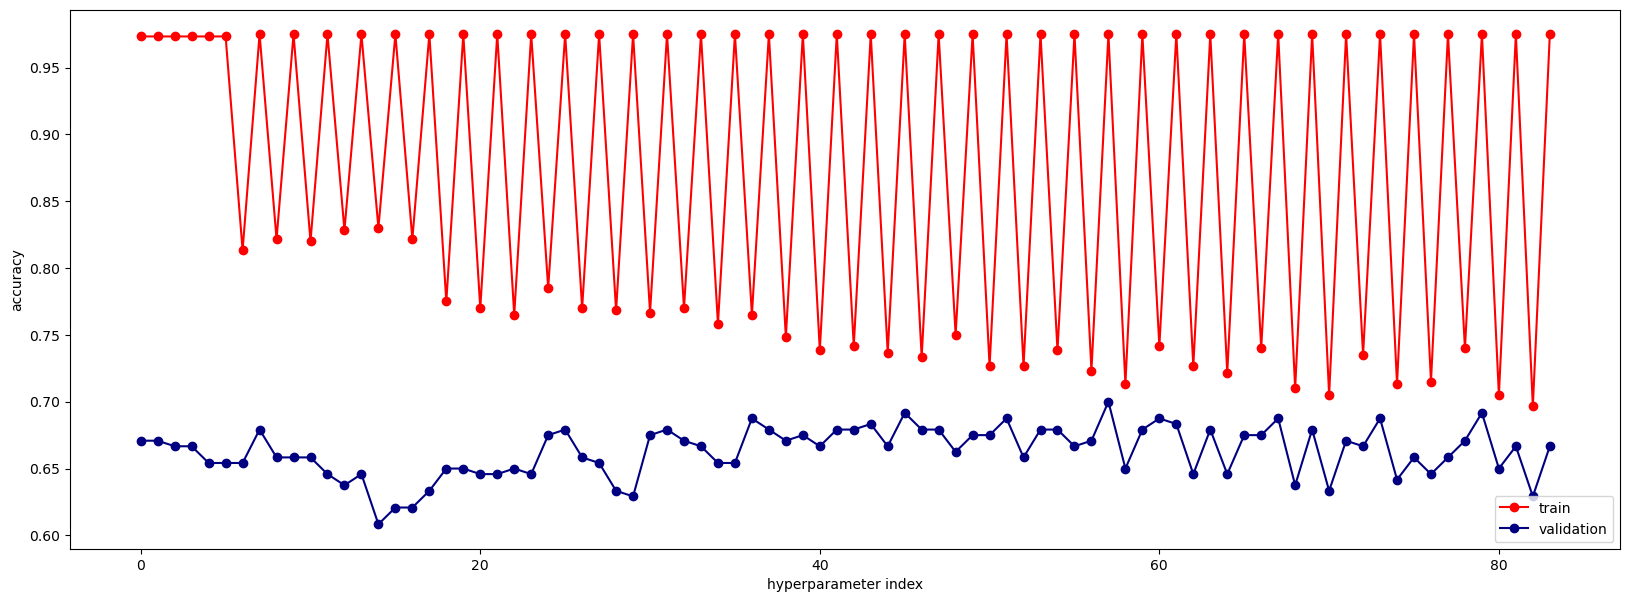

In [82]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(train_acc, 'o-', label='train', color='red')
ax.plot(val_acc, 'o-', label='validation', color='navy')
ax.set_xlabel('hyperparameter index')
ax.set_ylabel('accuracy')
ax.legend(loc="lower right")

In [83]:
best_params = param_comb[np.argmax(val_acc)]
best_params

{'weights': 'distance', 'p': 2, 'n_neighbors': 10}

In [84]:
best_clfKNN = KNeighborsClassifier(**best_params) 
best_clfKNN.fit(Xtrain, ytrain)

KNeighborsClassifier(n_neighbors=10, weights='distance')

In [85]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_clfKNN.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_clfKNN.predict(Xval))))

accuracy score (train): 0.975000
accuracy score (validation): 0.700000


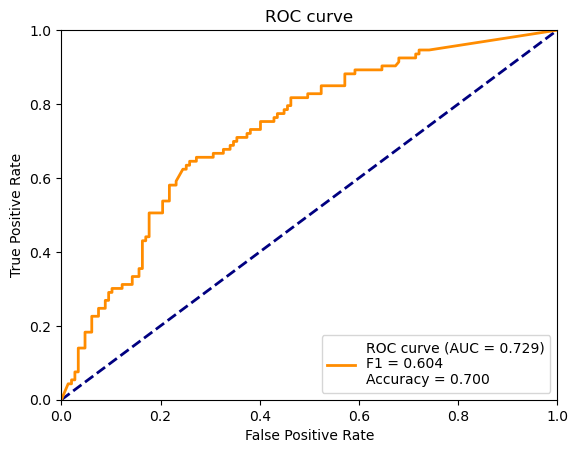

In [86]:
evaluate(clf=best_clfKNN, X=Xval, y_true=yval)

#### Min Max Normalizace
***

In [87]:
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xval)

In [88]:
param_grid = {
    "n_neighbors": range(1, 10),
    "weights": ["uniform", "distance"],
    "p": [1, 2, 3],
}
param_comb = ParameterGrid(param_grid)

In [89]:
val_acc = []
train_acc = []
for params in param_comb:
    clfKNN = KNeighborsClassifier(**params)
    clfKNN.fit(Xtrain_scaled, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, clfKNN.predict(Xtrain_scaled)))
    val_acc.append(metrics.accuracy_score(yval, clfKNN.predict(Xval_scaled)))

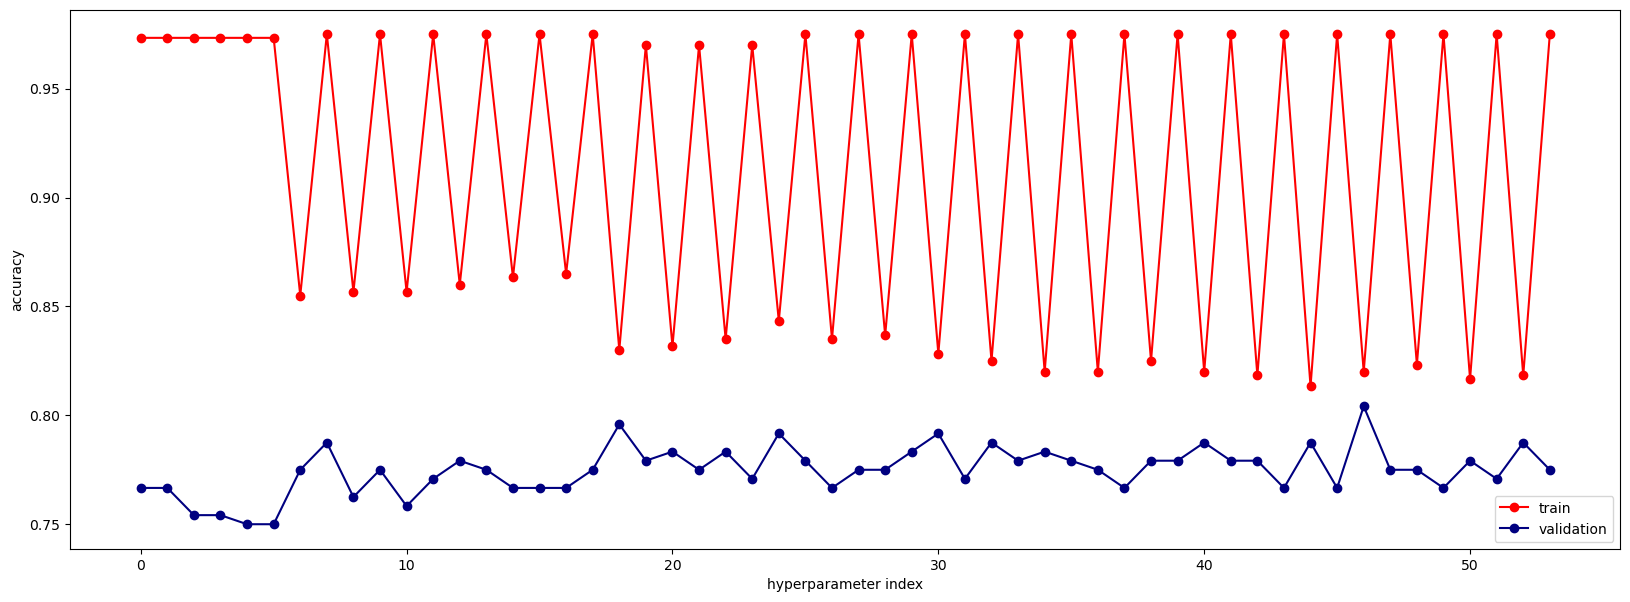

In [90]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(train_acc, 'o-', label='train', color='red')
ax.plot(val_acc, 'o-', label='validation', color='navy')
ax.set_xlabel('hyperparameter index')
ax.set_ylabel('accuracy')
ax.legend(loc="lower right")

In [91]:
best_params = param_comb[np.argmax(val_acc)]
best_params

{'weights': 'uniform', 'p': 3, 'n_neighbors': 8}

In [92]:
best_clfKNN = KNeighborsClassifier(**best_params) 
best_clfKNN.fit(Xtrain_scaled, ytrain)

KNeighborsClassifier(n_neighbors=8, p=3)

In [93]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_clfKNN.predict(Xtrain_scaled))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_clfKNN.predict(Xval_scaled))))

accuracy score (train): 0.820000
accuracy score (validation): 0.804167


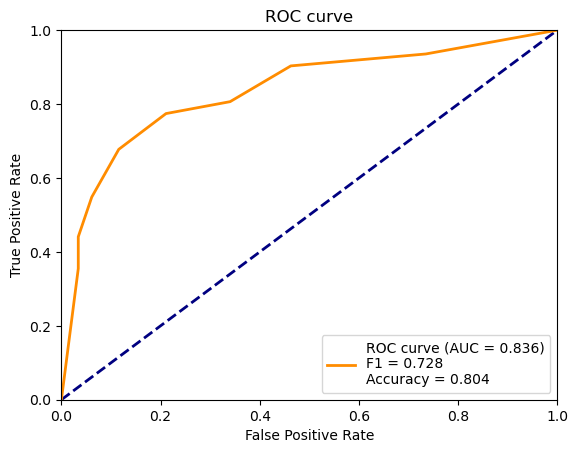

In [94]:
evaluate(clf=best_clfKNN, X=Xval_scaled, y_true=yval)

#### Standardizace
***

In [95]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xval)

In [96]:
param_grid = {
    "n_neighbors": range(1, 10),
    "weights": ["uniform", "distance"],
    "p": [1, 2, 3],
}
param_comb = ParameterGrid(param_grid)

In [97]:
val_acc = []
train_acc = []
for params in param_comb:
    clfKNN = KNeighborsClassifier(**params)
    clfKNN.fit(Xtrain_scaled, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, clfKNN.predict(Xtrain_scaled)))
    val_acc.append(metrics.accuracy_score(yval, clfKNN.predict(Xval_scaled)))

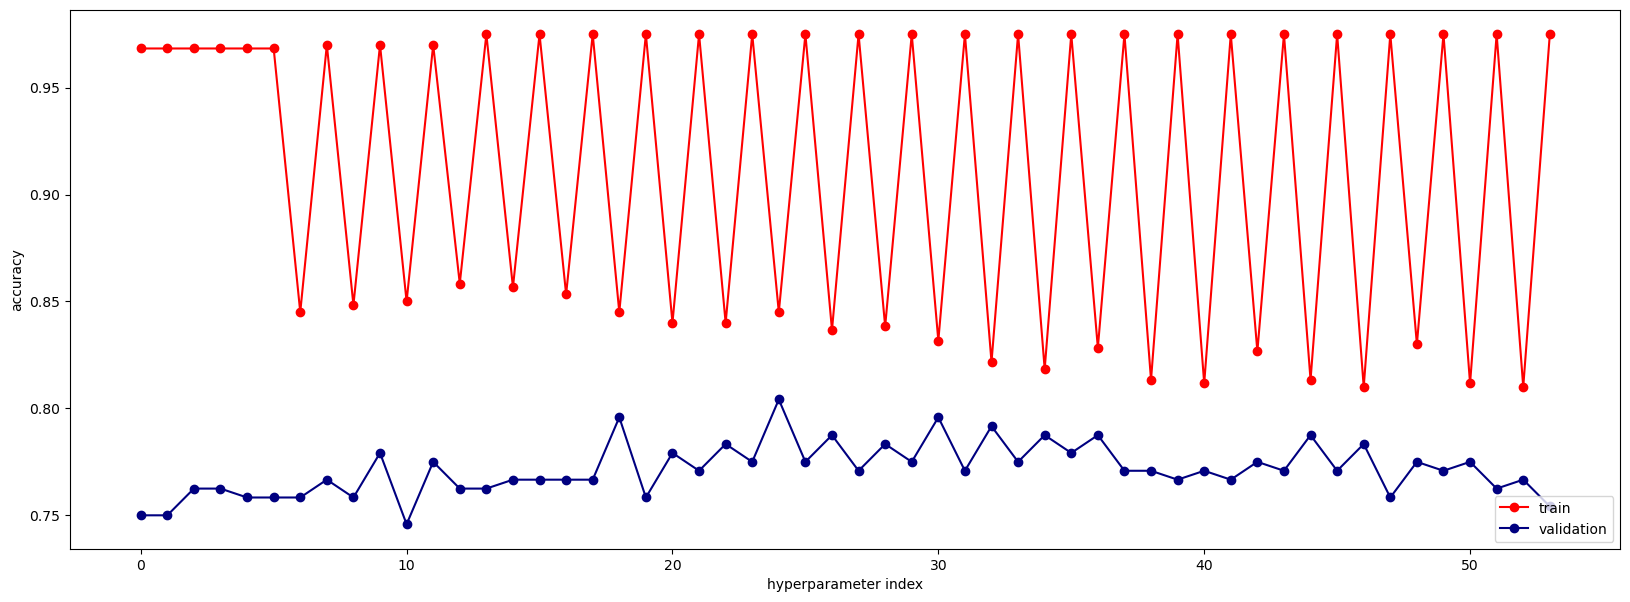

In [98]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(train_acc, 'o-', label='train', color='red')
ax.plot(val_acc, 'o-', label='validation', color='navy')
ax.set_xlabel('hyperparameter index')
ax.set_ylabel('accuracy')
ax.legend(loc="lower right")

In [99]:
best_params = param_comb[np.argmax(val_acc)]
best_params

{'weights': 'uniform', 'p': 1, 'n_neighbors': 5}

In [100]:
best_clfKNN = KNeighborsClassifier(**best_params) 
best_clfKNN.fit(Xtrain_scaled, ytrain)

KNeighborsClassifier(p=1)

In [101]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_clfKNN.predict(Xtrain_scaled))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_clfKNN.predict(Xval_scaled))))

accuracy score (train): 0.845000
accuracy score (validation): 0.804167


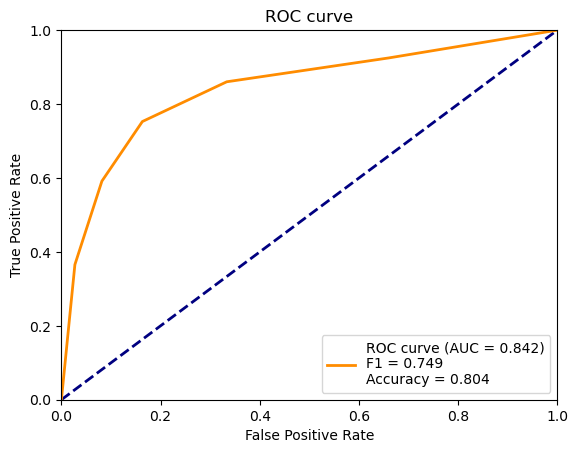

In [102]:
evaluate(clf=best_clfKNN, X=Xval_scaled, y_true=yval)

#### Cross validace a standartizace
***

In [103]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xval)

In [104]:
param_grid = {
    "n_neighbors": range(1, 10),
    "weights": ["uniform", "distance"],
    "p": [1, 2, 3],
}
param_comb = ParameterGrid(param_grid)

In [105]:
k_folds = 5

val_acc = []
train_acc = []


for params in param_comb:
    clfKNN = KNeighborsClassifier(**params)

    val_fold_accuracy = np.mean(
        cross_val_score(estimator=clfKNN, X=Xval_scaled, y=yval, cv=5)
    )

    train_fold_accuracy = np.mean(
        cross_val_score(estimator=clfKNN, X=Xtrain_scaled, y=ytrain, cv=5)
    )

    val_acc.append(val_fold_accuracy)
    train_acc.append(train_fold_accuracy)

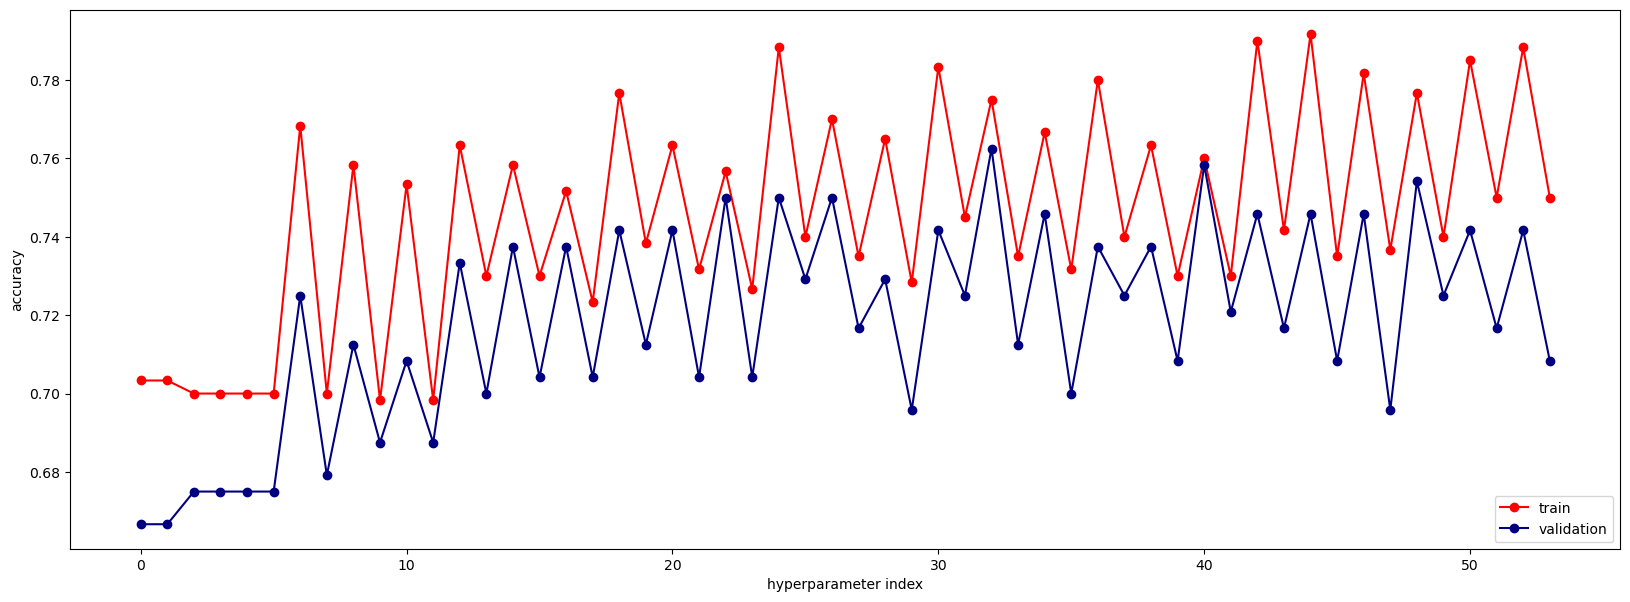

In [106]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(train_acc, 'o-', label='train', color='red')
ax.plot(val_acc, 'o-', label='validation', color='navy')
ax.set_xlabel('hyperparameter index')
ax.set_ylabel('accuracy')
ax.legend(loc="lower right")

In [107]:
best_params = param_comb[np.argmax(val_acc)]
best_params

{'weights': 'uniform', 'p': 2, 'n_neighbors': 6}

In [108]:
best_clfKNN = KNeighborsClassifier(**best_params) 
best_clfKNN.fit(Xtrain_scaled, ytrain)

KNeighborsClassifier(n_neighbors=6)

In [109]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_clfKNN.predict(Xtrain_scaled))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_clfKNN.predict(Xval_scaled))))

accuracy score (train): 0.821667
accuracy score (validation): 0.791667


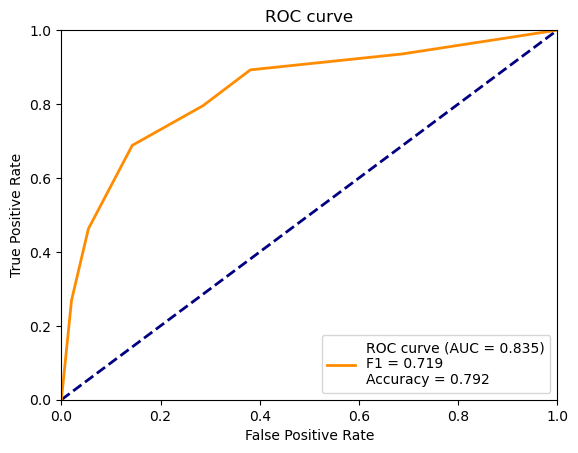

In [110]:
evaluate(clf=best_clfKNN, X=Xval_scaled, y_true=yval)

# 4. Final Results

## Finalni model a odhad presnosti

- finalni model - DT s parametry ...
- ocekavame .... presnost

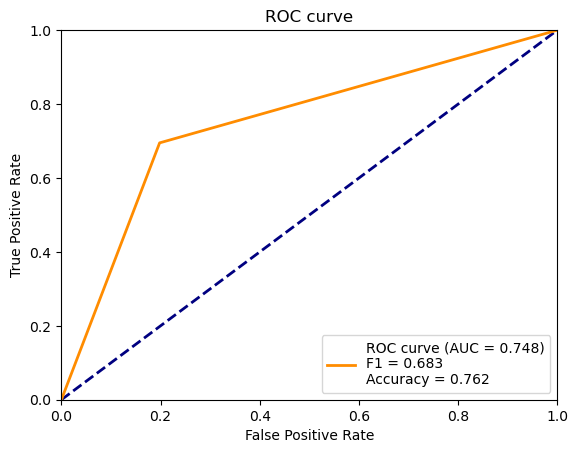

In [111]:
evaluate(clf=best_clfDT, X=Xtest, y_true=ytest)

## Predikce Evaluation

In [112]:
df_evaluation = pd.read_csv("evaluation.csv")

### First Look

In [113]:
df_evaluation.head()

,ID,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1000,3,"Stankovic, Mr. Ivan",male,33.0,0,0,349239,8.6625,NaN,C,NaN
1,1001,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S,"New York, NY"
2,1002,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,NaN,S,"New York, NY"
3,1003,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,NaN,S,NaN
4,1004,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C,NaN


In [114]:
df_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         309 non-null    int64  
 1   pclass     309 non-null    int64  
 2   name       309 non-null    object 
 3   sex        309 non-null    object 
 4   age        244 non-null    float64
 5   sibsp      309 non-null    int64  
 6   parch      309 non-null    int64  
 7   ticket     309 non-null    object 
 8   fare       309 non-null    float64
 9   cabin      62 non-null     object 
 10  embarked   309 non-null    object 
 11  home.dest  179 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 29.1+ KB


In [115]:
df_evaluation.describe()

,ID,pclass,age,sibsp,parch,fare
count,309.000000,309.000000,244.000000,309.000000,309.000000,309.000000
mean,1154.000000,2.317152,29.981216,0.508091,0.330097,30.163106
std,89.344838,0.831442,14.718045,1.097858,0.670167,46.312684
min,1000.000000,1.000000,0.750000,0.000000,0.000000,0.000000
25%,1077.000000,2.000000,21.000000,0.000000,0.000000,7.879200
50%,1154.000000,3.000000,29.000000,0.000000,0.000000,13.500000
75%,1231.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1308.000000,3.000000,71.000000,8.000000,5.000000,512.329200


In [116]:
df_evaluation.select_dtypes(include=['object']).describe()

,name,sex,ticket,cabin,embarked,home.dest
count,309,309,309,62,309,179
unique,309,2,284,55,3,134
top,"Stankovic, Mr. Ivan",male,S.O.C. 14879,E101,S,"New York, NY"
freq,1,215,4,2,216,18


### Transformace

In [117]:
IDs = df_evaluation['ID']

In [118]:
df_evaluation.drop(columns=["ID", "name", "ticket", "cabin", "home.dest"], inplace=True)

In [119]:
df_evaluation.fillna(value=-1, inplace=True)
df_evaluation["pclass"] = df_evaluation["pclass"].astype(cat_pclass)
df_evaluation["sex"] = df_evaluation["sex"].astype(cat_sex)
df_evaluation = pd.get_dummies(data=df_evaluation, columns=["embarked"])

In [120]:
df_evaluation.head()

,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,3,male,33.0,0,0,8.6625,True,False,False
1,1,female,-1.0,0,0,31.6833,False,False,True
2,1,female,-1.0,1,0,133.6500,False,False,True
3,3,male,47.0,0,0,9.0000,False,False,True
4,1,female,58.0,0,0,146.5208,True,False,False


In [121]:
for col in df_evaluation.select_dtypes(['category']).columns:
    df_evaluation[col] = df_evaluation[col].cat.codes

In [122]:
df_evaluation.head()

,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,0,0,33.0,0,0,8.6625,True,False,False
1,2,1,-1.0,0,0,31.6833,False,False,True
2,2,1,-1.0,1,0,133.6500,False,False,True
3,0,0,47.0,0,0,9.0000,False,False,True
4,2,1,58.0,0,0,146.5208,True,False,False


### Predikce a export

In [123]:
ypred = best_clfDT.predict(X=df_evaluation)

In [124]:
evaluation = pd.DataFrame( data={'survived': ypred}, index=IDs)
evaluation.head()

,survived
ID,
1000,0
1001,1
1002,1
1003,0
1004,1


In [125]:
evaluation.to_csv("results.csv")